In [4]:
# ==============================================================================
# ML-CUP25 - Tree-Based Models Comparison (RF, XGB, LGBM)
# ------------------------------------------------------------------------------
# Description:
#   Comparison of Random Forest, XGBoost, and LightGBM for multi-target regression.
#   Best model is selected via 5-Fold Cross-Validation minimizing MEE.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

In [5]:
# ==============================================================================
# 1. DATA LOADING
# ==============================================================================
filename = 'ML-CUP25-TR.csv'
try:
    df = pd.read_csv(filename, comment='#', header=None)
except FileNotFoundError:
    print("Dataset not found. Please check the file path.")
    exit()

# Features (X) and Targets (y)
X = df.iloc[:, 1:-4].values
y = df.iloc[:, -4:].values

# Split 80% Dev - 20% Test
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Data Loaded. Dev: {X_dev.shape}, Test: {X_test.shape}")

Data Loaded. Dev: (400, 12), Test: (100, 12)


In [6]:
# ==============================================================================
# 2. CONFIGURATION & MODELS
# ==============================================================================

# Custom Scorer: Mean Euclidean Error (MEE)
def mee_score_func(y_true, y_pred):
    dist = np.sqrt(np.sum(np.power(y_true - y_pred, 2), axis=1))
    return np.mean(dist)

mee_scorer = make_scorer(mee_score_func, greater_is_better=False)

# Define Candidates
model_candidates = {}

# --- 1. Random Forest ---
# Natively supports multi-output
model_candidates['RandomForest'] = {
    'estimator': RandomForestRegressor(random_state=42),
    'params': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'max_features': ['sqrt', None] # 'sqrt' is often better for high dim
    }
}

# --- 2. XGBoost ---
# Needs MultiOutputRegressor wrapper
model_candidates['XGBoost'] = {
    'estimator': MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)),
    'params': {
        'estimator__n_estimators': [100, 200],
        'estimator__learning_rate': [0.05, 0.1],
        'estimator__max_depth': [3, 5, 7]
    }
}

# --- 3. LightGBM ---
# Needs MultiOutputRegressor wrapper
model_candidates['LightGBM'] = {
    'estimator': MultiOutputRegressor(lgb.LGBMRegressor(random_state=42, verbose=-1)),
    'params': {
        'estimator__n_estimators': [100, 200],
        'estimator__learning_rate': [0.05, 0.1],
        'estimator__num_leaves': [31, 50]
    }
}

In [7]:
# ==============================================================================
# 3. TRAINING & SELECTION LOOP
# ==============================================================================
results = []
best_overall_model = None
best_overall_score = float('inf') # We want to minimize MEE
best_overall_name = ""

print("\n--- Starting Model Selection (5-Fold CV) ---")

for name, config in model_candidates.items():
    print(f"Training {name}...")

    grid = GridSearchCV(
        config['estimator'],
        config['params'],
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring=mee_scorer,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_dev, y_dev)

    # Store results
    # Note: best_score_ is negative MEE, so we negate it back
    mean_cv_mee = -grid.best_score_
    print(f"  -> Best MEE: {mean_cv_mee:.4f} | Params: {grid.best_params_}")

    results.append({
        'Model': name,
        'CV_MEE': mean_cv_mee,
        'Best_Params': grid.best_params_
    })

    # Check if this is the new best model
    if mean_cv_mee < best_overall_score:
        best_overall_score = mean_cv_mee
        best_overall_model = grid.best_estimator_
        best_overall_name = name



--- Starting Model Selection (5-Fold CV) ---
Training RandomForest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
  -> Best MEE: 21.2123 | Params: {'max_depth': 10, 'max_features': None, 'n_estimators': 200}
Training XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
  -> Best MEE: 21.3419 | Params: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 5, 'estimator__n_estimators': 200}
Training LightGBM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
  -> Best MEE: 22.3063 | Params: {'estimator__learning_rate': 0.05, 'estimator__n_estimators': 200, 'estimator__num_leaves': 31}


In [8]:
# ==============================================================================
# 4. FINAL EVALUATION
# ==============================================================================

print("\n--- Leaderboard ---")
leaderboard = pd.DataFrame(results).sort_values(by='CV_MEE')
print(leaderboard[['Model', 'CV_MEE']])

print(f"\n🏆 WINNER: {best_overall_name} (CV MEE: {best_overall_score:.4f})")

# Predict on Blind Test Set
y_pred = best_overall_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mee = mee_score_func(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Performance on Test Set ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Euclidean Error (MEE): {mee:.4f}")
print(f"R2 Score: {r2:.4f}")




--- Leaderboard ---
          Model     CV_MEE
0  RandomForest  21.212276
1       XGBoost  21.341941
2      LightGBM  22.306251

🏆 WINNER: RandomForest (CV MEE: 21.2123)

--- Performance on Test Set ---
Mean Squared Error (MSE): 135.1649
Mean Euclidean Error (MEE): 20.6087
R2 Score: 0.5566



Plot saved as 'tree_models_comparison.pdf'


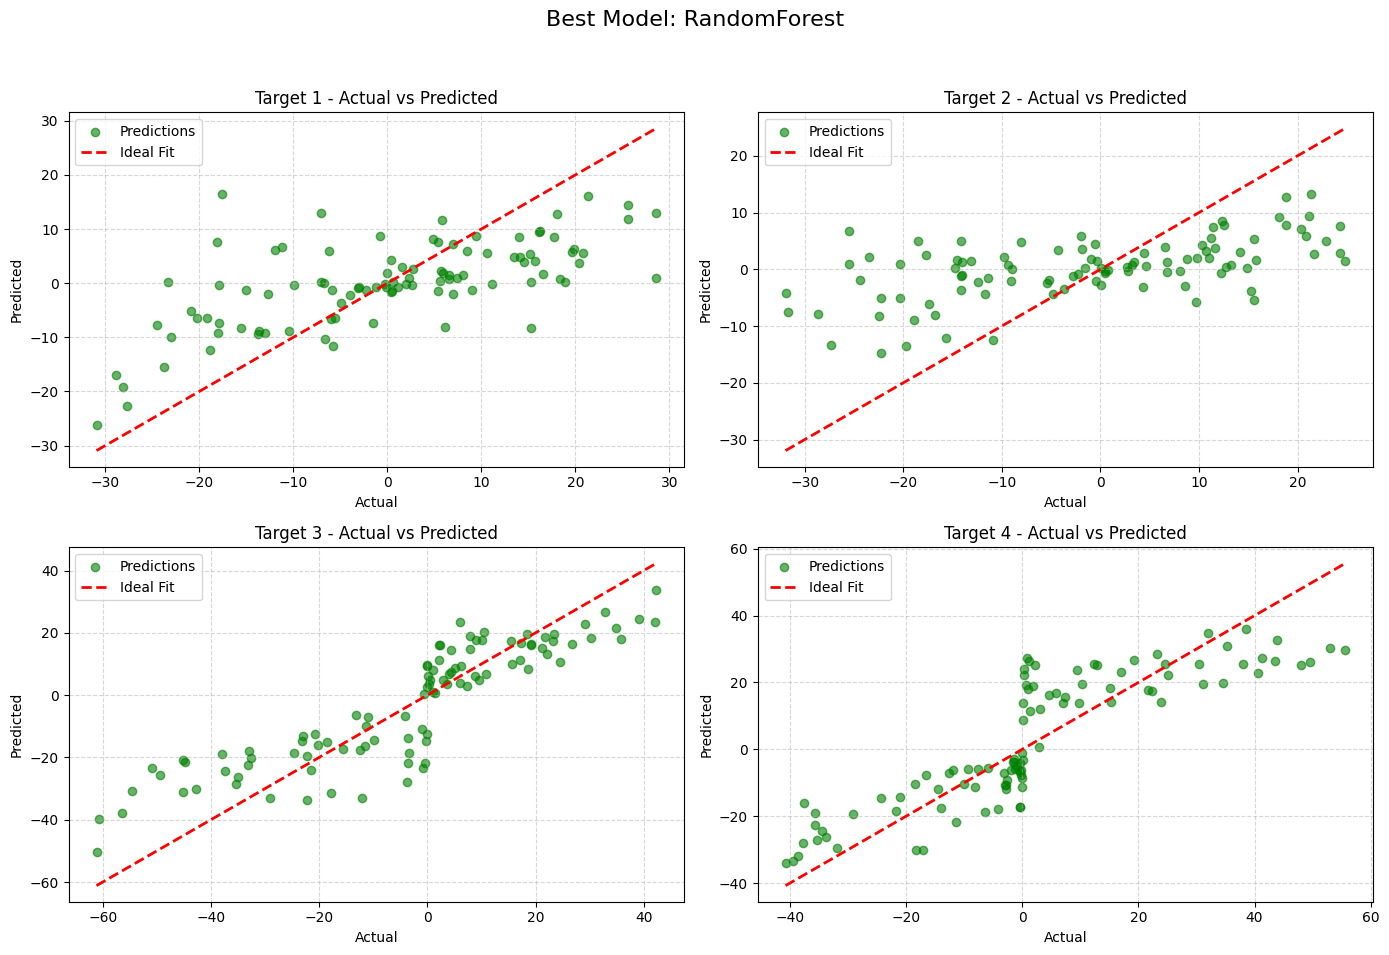

In [9]:
# ==============================================================================
# 5. PLOTTING
# ==============================================================================

target_labels = ['Target 1', 'Target 2', 'Target 3', 'Target 4']
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

for i in range(4):
    axs[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.6, color='green', label='Predictions')
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')
    axs[i].set_title(f'{target_labels[i]} - Actual vs Predicted')
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.5)

plt.suptitle(f'Best Model: {best_overall_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save Plot
plt.savefig('tree_models_comparison.pdf', bbox_inches='tight')
print("\nPlot saved as 'tree_models_comparison.pdf'")
plt.show()